In [87]:
import pandas as pd
import numpy as np
from PIL import Image
from IPython.display import display
import os
import imageio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms 
import albumentations as A

In [10]:
folders = ['dataA','dataB','dataC','dataD','dataE']
image_folder = 'CameraRGB'
mask_folder = 'CameraSeg'

In [11]:
data = []
base = '../input/lyft-udacity-challenge/'
for folder in folders:
    image_path = os.path.join(base,folder+"/"+folder, image_folder)
    mask_path = os.path.join(base,folder+"/"+folder, mask_folder)
    
    image_files = os.listdir(image_path)
    mask_files = os.listdir(mask_path)
    
    for image_file, mask_file in zip(image_files, mask_files):
        image_full_path = os.path.join(image_path, image_file)
        mask_full_path = os.path.join(mask_path, mask_file)
        
        data.append({'id': image_file.split('.')[0], 'imagepath': image_full_path, 'maskpath': mask_full_path})

df = pd.DataFrame(data)

In [147]:
class SDCDataSet(Dataset):
    def __init__(self,imgData):
        self.train = train
        self.imgData = imgData
        self.transform = A.Compose([
                            A.RandomCrop(width=256, height=256),
                            A.HorizontalFlip(p=0.2),
                            A.RandomBrightnessContrast(p=0.2),
                        ])
    def __len__(self):
        return len(self.imgData)
    def __getitem__(self,idx):
        img = imageio.v3.imread(self.imgData.iloc[idx].imagepath)
        mask = imageio.v3.imread(self.imgData.iloc[idx].maskpath,mode="L")
        transformed = self.transform(image=img, mask=mask)
        return transformed['image'],transformed['mask']  

In [148]:
train,test = train_test_split(df,test_size=0.2)

In [149]:
train_ds = SDCDataSet(train)
valid_ds = SDCDataSet(test)

In [150]:
len(valid_ds)

1000

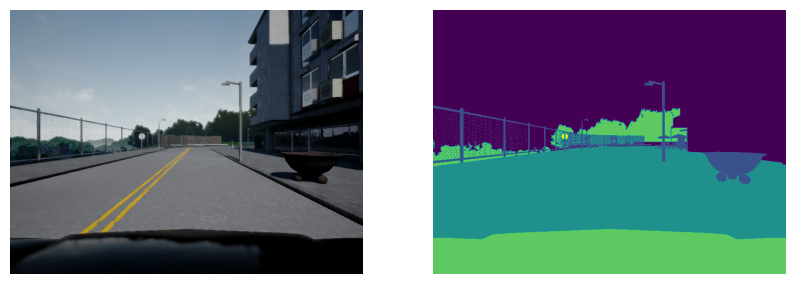

In [153]:

img,mask = train_ds[970]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
#plt.title(f'Image {i+1} - Subfolder: {subfolder}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask)  # Display mask in grayscale
#plt.title(f'Mask {i+1} - Subfolder: {subfolder}')
plt.axis('off')


plt.show()